In [1]:
import pandas as pd
import seaborn as sns
import pandas as pd
import warnings
from matplotlib.lines import Line2D
import os
import scanpy as sc
import numpy as np
import torch
import random

import sys
sys.path.append(os.path.abspath("../"))
from metrics import spearman_score, pearson_score, root_mean_square_error, mean_square_error
from utils import random_splits

from scipy.stats import norm, rankdata
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['pdf.fonttype'] = 42  # Ensures text is stored as editable Type 1 fonts
plt.rcParams['ps.fonttype'] = 42   # For EPS compatibility

warnings.simplefilter(action="ignore", category=Warning)

def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

fix_seed(42)

dir_path1 = '/ewsc/wuqitian/hest_data_xenium_protein_preprocess'
meta_info1 = pd.read_csv("../../data/meta_info_xenium.csv")

dir_path2 = '/ewsc/wuqitian/lung_preprocess'
meta_info2 = pd.read_csv("../../data/meta_info_lung.csv")

result_path = '/ewsc/wuqitian/analysis_pred_data/gene_expression_prediction/'

cell_lineage = ['Epithelial', 'Immune', 'Endothelial', 'Mesenchymal']
cl_map = {c: i for i, c in enumerate(cell_lineage)}
cl_map_inv = {i: c for i, c in enumerate(cell_lineage)}
cell_type = ['RASC', 'Secretory', 'Multiciliated', 'PNEC', 'Basal', 'Goblet', 'Proliferating Airway', 'AT2', 'Transitional AT2', 'AT1', 
             'KRT5-/KRT17+', 'Proliferating AT2', 'Langerhans cells', 'NK/NKT', 'Tregs', 'CD4+ T-cells', 'CD8+ T-cells', 
             'Proliferating T-cells', 'B cells', 'Plasma', 'pDCs', 'Proliferating NK/NKT', 'Proliferating B cells', 'cDCs', 'Mast', 
             'Interstitial Macrophages', 'Alveolar Macrophages', 'SPP1+ Macrophages', 'Neutrophils', 'Proliferating Myeloid', 
             'Migratory DCs', 'Macrophages - IFN-activated', 'Monocytes/MDMs', 'Basophils', 'Venous', 'Capillary', 'Lymphatic', 
             'Arteriole', 'SMCs/Pericytes', 'Alveolar FBs', 'Proliferating FBs', 'Inflammatory FBs', 'Activated Fibrotic FBs', 
             'Myofibroblasts', 'Subpleural FBs', 'Adventitial FBs', 'Mesothelial']
ct_map = {c: i for i, c in enumerate(cell_type)}
ct_map_inv = {i: c for i, c in enumerate(cell_type)}

def pearson_score(y_true, y_pred, rank_axis='by_gene'):

    axis = 1 if rank_axis == 'by_gene' else 0

    matrix1 = y_true - np.mean(y_true, axis=axis, keepdims=True)
    matrix2 = y_pred - np.mean(y_pred, axis=axis, keepdims=True)

    covariance = np.sum(matrix1 * matrix2, axis=axis, keepdims=True)

    std1 = np.sqrt(np.sum(matrix1 ** 2, axis=axis, keepdims=True))
    std2 = np.sqrt(np.sum(matrix2 ** 2, axis=axis, keepdims=True))

    std_prod = std1 * std2

    if rank_axis == 'by_gene':
        nonzero = std_prod.nonzero()[0]
        corrs = covariance[nonzero] / std_prod[nonzero]
    else:
        nonzero = std_prod.nonzero()[1]
        corrs = covariance[:, nonzero] / std_prod[:, nonzero]

    return np.mean(corrs)

def spearman_score(y_true, y_pred, rank_axis='by_gene'):

    axis = 1 if rank_axis == 'by_gene' else 0

    ranked_matrix1 = np.apply_along_axis(rankdata, axis=axis, arr=y_true)
    ranked_matrix2 = np.apply_along_axis(rankdata, axis=axis, arr=y_pred)

    ranked_matrix1 -= np.mean(ranked_matrix1, axis=axis, keepdims=True)
    ranked_matrix2 -= np.mean(ranked_matrix2, axis=axis, keepdims=True)

    covariance = np.sum(ranked_matrix1 * ranked_matrix2, axis=axis, keepdims=True)

    std1 = np.sqrt(np.sum(ranked_matrix1 ** 2, axis=axis, keepdims=True))
    std2 = np.sqrt(np.sum(ranked_matrix2 ** 2, axis=axis, keepdims=True))

    std_prod = std1 * std2

    if rank_axis == 'by_gene':
        nonzero = std_prod.nonzero()[0]
        corrs = covariance[nonzero] / std_prod[nonzero]
    else:
        nonzero = std_prod.nonzero()[1]
        corrs = covariance[:, nonzero] / std_prod[:, nonzero]

    return np.mean(corrs)

def mutual_information_kl(X, Y, bins=50):
    min_val, max_val = np.min(X), np.max(X)
    bin_edges = np.linspace(min_val, max_val, bins + 1)

    # Compute marginal probabilities
    p_x, _ = np.histogram(X, bins=bin_edges, density=True)
    p_x /= np.sum(p_x)

    p_y, _ = np.histogram(Y, bins=bin_edges, density=True)
    p_y /= np.sum(p_y)

    # Compute joint probability
    p_xy, _, _ = np.histogram2d(X, Y, bins=[bin_edges, bin_edges], density=True)
    p_xy /= np.sum(p_xy)

    # Compute MI using KL divergence
    p_xp_y = np.outer(p_x, p_y)
    p_xp_y = np.clip(p_xp_y, 1e-10, None)  # Avoid log(0)
    p_xy = np.clip(p_xy, 1e-10, None)

    mi = np.sum(p_xy * np.log(p_xy / p_xp_y))
    return mi

def conditional_mutual_information(X, Z, Y, bins=50):
    mi_x_y = np.sum([mutual_information_kl(X, Y[:, i], bins) for i in range(Y.shape[1])])  # MI(X; Y)
    mi_x_yz = np.sum([mutual_information_kl(X, Y[:, i], bins) for i in range(Y.shape[1])]) + mutual_information_kl(X, Z, bins)  # MI(X; Y, Z)

    return mi_x_yz - mi_x_y

def transformation(x, norm):
    x = x / norm * 1e4
    x = np.log1p(x)
    return x

def normalize(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-5)

def compute_conditional_entropy(y, X):
    cond_ents = [mutual_information_kl(y, y) - mutual_information_kl(y, X[:, i]) for i in range(X.shape[1])]
    return cond_ents

/local_home/wuqitian/anaconda3/envs/bio/lib/python3.12/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /local_home/wuqitian/anaconda3/envs/bio/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/local_home/wuqitian/anaconda3/envs/bio/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /local_home/wuqitian/anaconda3/envs/bio/lib/python3.12/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [3]:
import scipy.stats as stats

samples = ['TENX135', 'TENX136', 'TENX137']

marker_genes = ['DCPP2', 'CLCNKA', 'FAM183B', 'REG3G', 'NANOG', 'CLDN4', 'CLCNKB', 'CCL12', 'UOX',
 'COX8B', 'SERPINA3N', 'CALM4', 'TRY10', 'DBPHT2', 'CD300C', 'FOLR2', 'XCL1',
 'APOC2', 'PRSS3', 'HSD3B4', 'AQP7', 'NBL1', 'KLK1', 'KLRE1', 'FCGR1', 'KLRA8',
 'KNG2', 'METTL7A2', 'SIGLECH', 'MCPT8', 'CTLA2A', 'CLEC4A3', 'CFH', 'STFA2L1',
 'MS4A6B', 'SELENBP1', 'CD300LD', 'CSTDC4', 'PF4', 'FCGR4']

genes, methods, scores, corrs = [], [], [], []

for sample in samples:
    file_path = os.path.join(dir_path1, sample) + '.h5ad'
    adata = sc.read(file_path)
                        
    file_path = result_path + f'{sample}_true.npy'
    y_true = np.load(file_path)
    sum_norm = y_true.sum(-1, keepdims=True) + 1e-5

    file_path = result_path + f'{sample}_ours.npy'
    y_pred = np.load(file_path)

    gene_filter_mask = adata.var['gene_filter_mask']
    new_gene_list = adata.var['gene_names'][~gene_filter_mask]
    old_gene_list = adata.var['gene_names'][gene_filter_mask]
    y_true_old = y_true[:, gene_filter_mask]

    for marker_gene in marker_genes:
        gene_mask = adata.var['gene_names']==marker_gene.capitalize()
        y_true_m = y_true[:, gene_mask]
        y_pred_m = y_pred[:, gene_mask]
            
        score = ((y_true_m - y_pred_m) ** 2).mean()
#         if score1 < 2:
        genes += [marker_gene]
        methods += ['Ours']
        scores += [score]
        
        cond_ent_m = compute_conditional_entropy(y_true_m.reshape(-1), y_true_old) # conditional entropy
        corrs += [np.min(cond_ent_m)]
        print(marker_gene, score, corrs[-1])
    print(sample)

model_color = ['#b2182b', '#377eb8']
genes = list(map(lambda x: x.upper(), genes))
result_df = pd.DataFrame({'gene': genes, 'method': methods, 'score': scores, 'corr': corrs})

corr_df = result_df[['gene', 'corr']].groupby(['gene']).mean()
corr_df['mean'] = result_df[['gene', 'score']].groupby(['gene']).mean()
corr_df = corr_df.sort_values(by='mean')

DCPP2 0.015956942 0.005382199137435508
CLCNKA 0.012309846 0.00412589911905118
FAM183B 0.015420402 0.005161627838562411
REG3G 0.03247471 0.010494975968125285
NANOG 0.025236078 0.007777638794732559
CLDN4 0.025680283 0.008247709089641111
CLCNKB 0.025813008 0.008368555117630407
CCL12 0.053589474 0.016622063254061997
UOX 0.033351734 0.010384511925046034
COX8B 0.10159687 0.02593505106370309
SERPINA3N 0.0705104 0.0209553511385285
CALM4 0.059355192 0.017403949047121944
TRY10 0.06346803 0.01834793079141884
DBPHT2 0.08807897 0.025248938373472037
CD300C 0.16249898 0.04249802815750961
FOLR2 0.12969325 0.03188430941252398
XCL1 0.17135045 0.04000405727279973
APOC2 0.23528324 0.06132623876646393
PRSS3 0.116866626 0.03199386912878714
HSD3B4 0.12195654 0.030580145767326768
AQP7 0.35612386 0.0724338470133923
NBL1 0.42904425 0.10008771016469735
KLK1 0.3416822 0.07861037721297634
KLRE1 0.49826905 0.11261602774041328
FCGR1 0.5381225 0.12283106849970518
KLRA8 0.4225954 0.09813162894120793
KNG2 0.8690842 0.1

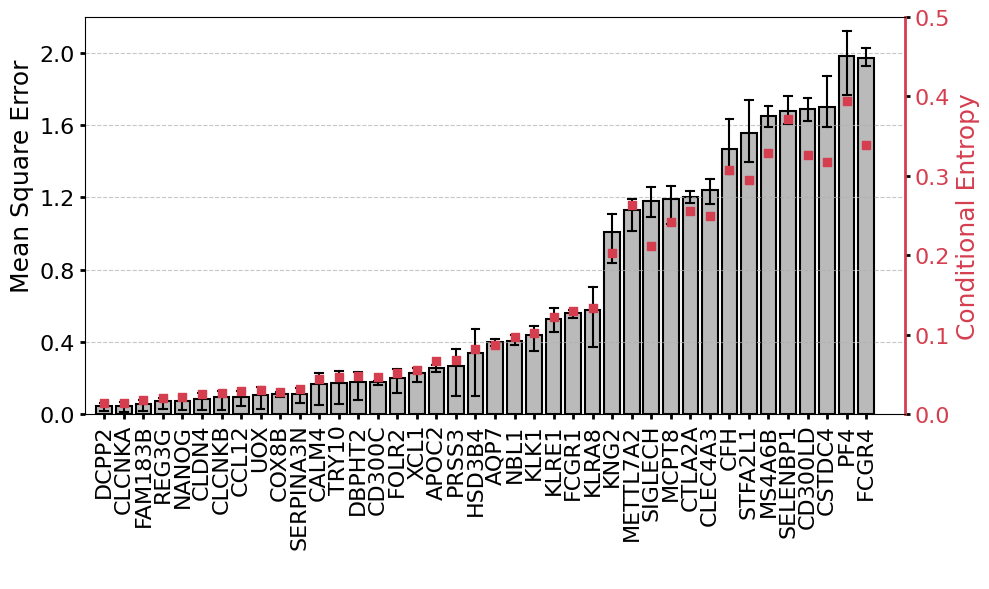

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    result_df, x="gene", y="score",
    errorbar=("pi", 50), capsize=.4,
    err_kws={"color": "black", "linewidth": 1.5},
    linewidth=1.5, edgecolor="black", order=marker_genes, color='#bababa'
)

ax.set_xlabel(' ', fontsize=18)
ax.tick_params(axis='x', labelsize=16, width=2)
ax.set_xlim(-1, len(marker_genes)+1) 
ax.tick_params(axis='y', labelcolor='black', labelsize=16, width=2)
ax.set_ylim(0., 2.2) 
ax.set_yticks([0., 0.4, 0.8, 1.2, 1.6, 2.0]) 
ax.set_ylabel(r'          Mean Square Error', fontsize=18, color='black')
ax.set_xticklabels(marker_genes, rotation=90)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(2)

ax2 = ax.twinx()  
ax2.set_ylabel('Conditional Entropy', fontsize=18, color='#d53e4f')  # we already handled the x-label with ax1
ax2.scatter(np.arange(len(marker_genes)), corr_df['corr'].to_numpy(), color='#d53e4f', marker="s", s=30)
ax2.tick_params(axis='y', labelcolor='#d53e4f', labelsize=16, width=2)
ax2.set_ylim(0., 0.5) 
ax2.set_yticks([0., 0.1, 0.2, 0.3, 0.4, 0.5]) 
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax2.spines['right'].set_color('#d53e4f')
ax2.spines['right'].set_linewidth(2)

# ax.legend(loc='upper center', fontsize=20, marker="+"ncols=2, bbox_to_anchor=(0.5, 1.2), frameon=False)

plt.tight_layout()
plt.savefig('../../figure/pred_xenium_new_gene_bone.pdf')
plt.show()

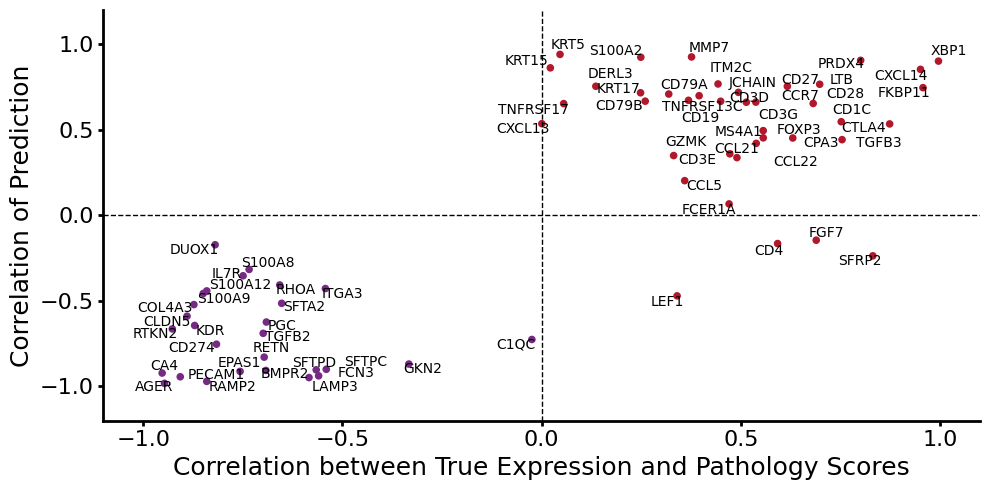

In [12]:
from adjustText import adjust_text
from scipy.special import logit

samples = ['THD0008', 'VUHD113', 'VUILD48LA2', 'VUILD78LA', 'VUILD91MA', 'VUILD102MA']

for i, sample in enumerate(samples):
    file_path = os.path.join(dir_path2, sample) + '.h5ad'
    adata_i = sc.read(file_path)
    gene_filter_mask = adata_i.var['gene_filter_mask']
    adata_i = adata_i[:, gene_filter_mask]        
    path_score_i = adata_i.obs['percent_pathology'].to_numpy()[:1]
        
    file_path = result_path + f'{sample}_true.npy'
    y_true_i = np.load(file_path)
    y_true_i = y_true_i.sum(0, keepdims=True) / y_true_i.sum()

    file_path = result_path + f'{sample}_ours.npy'
    y_pred_i = np.load(file_path)
    y_pred_i = y_pred_i.sum(0, keepdims=True) / y_pred_i.sum()

    if i == 0:
        path_score = path_score_i
        y_true = y_true_i
        y_pred = y_pred_i
    else:
        path_score = np.concatenate([path_score, path_score_i], axis=0)
        y_true = np.concatenate([y_true, y_true_i], axis=0)
        y_pred = np.concatenate([y_pred, y_pred_i], axis=0)

gene_name_list = adata_i.var['gene_names'].tolist()
gene_names, scores1, scores2, gaps = [], [], [], []
for m in range(y_true.shape[1]):
    y_true_m, y_pred_m = y_true[:, m].reshape(-1, 1), y_pred[:, m].reshape(-1, 1)

    score1 = pearson_score(path_score.reshape(-1, 1), y_true_m, 'by_cell')
    score2 = pearson_score(path_score.reshape(-1, 1), y_pred_m, 'by_cell')
    gene_names.append(gene_name_list[m])
    scores1.append(score1)
    scores2.append(score2)

gene_names, scores1, scores2, gaps = np.array(gene_names), np.array(scores1), np.array(scores2), np.array(gaps)
idx = np.arange(scores1.shape[0])
gene_names = gene_names[idx]
scores1, scores2 = scores1[idx], scores2[idx]

fig, ax = plt.subplots(figsize=(10, 5))


neg_gene_names = ['AGER', 'CA4', 'FCN3', 'EPAS1', 'RTKN2', 'LAMP3', 'PECAM1', 'BMPR2', 'CLDN5', 'COL4A3', 'SFTA2', 'SFTPD', 'SFTPC', 
                       'S100A12', 'S100A9', 'S100A8', 'DUOX1', 'KDR', 'RHOA', 'MRC1', 'C1QC', 'CD274', 'RETN', 'PGC', 'RAMP2',
                  'ITGA3', 'FCER1G', 'CD68', 'GKN2', 'NAPSA', 'PPARG', 'TGFB2', 'IL7R', 'HMOX1', 'MCEMP1']
pos_gene_names = ['CXCL14', 'SFRP2', 'JCHAIN', 'KRT5', 'CD79A', 'MMP7', 'CD27', 'ITM2C', 'CD28', 'FCER1A', 'CCL22', 'CCR7', 'FOXP3', 
                  'DERL3', 'CD79B', 'TNFRSF17', 'TNFRSF13C', 'MS4A1', 'S100A2', 'LTB', 'CD1C', 'TGFB3', 'PRDX4', 'KRT17', 'CD19',
                  'ERN2', 'MUC5B', 'CXCL13', 'MMP12', 'CTLA4', 'GZMK', 'CCL21', 'MEG3', 'FKBP11', 'CD3E', 'CPA3', 
                  'CCL5', 'LEF1', 'FGF7', 'CD4', 'PDCD1', 'CD3G', 'XBP1', 'KRT15', 'CD3D']

idx = np.arange(scores1.shape[0])

texts1 = []
for gene in neg_gene_names:
    if (gene_names==gene).sum() > 0:
        p = idx[gene_names==gene]
        if scores1[p] < 0:
            ax.scatter(scores1[p], scores2[p], c='#762a83', edgecolors='none', s=30.0)
            texts1.append(ax.annotate(gene, (scores1[p], scores2[p]), ha='center', va='center'))
adjust_text(texts1, avoid_self=True, expand=(2, 2))

texts2 = []
for gene in pos_gene_names:
    if (gene_names==gene).sum() > 0:
        p = idx[gene_names==gene]
        if scores1[p] > 0:
            ax.scatter(scores1[p], scores2[p], c='#b2182b', edgecolors='none', s=30.0)
            texts2.append(ax.annotate(gene, (scores1[p], scores2[p]), ha='center', va='center'))
adjust_text(texts2, avoid_self=True, expand=(1, 1))

ax.set_xlabel('Correlation between True Expression and Pathology Scores', fontsize=18)
ax.set_ylabel('Correlation of Prediction', fontsize=18)
ax.tick_params(axis='x', labelsize=16, width=2)
ax.tick_params(axis='y', labelsize=16, width=2)
ax.set_ylim(-1.2, 1.2) 
ax.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0]) 
ax.set_xlim(-1.1, 1.1) 
ax.set_xticks([-1.0, -0.5, 0.0, 0.5, 1.0]) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.plot([-1.1, 1.1], [0, 0], color="k", linestyle="--", linewidth=1)
ax.plot([0, 0], [-1.2, 1.2], color="k", linestyle="--", linewidth=1)

plt.tight_layout()
plt.savefig('../../figure/pred_xenium_patho_corr.pdf')
plt.show()

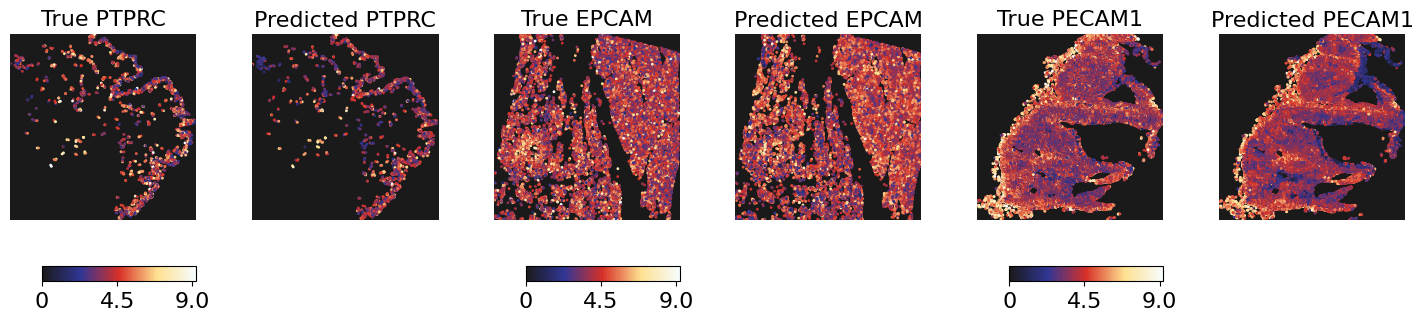

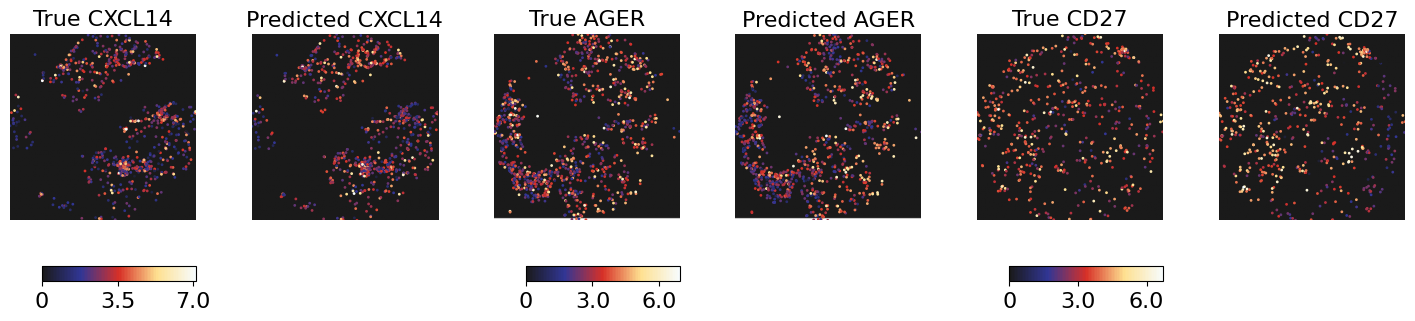

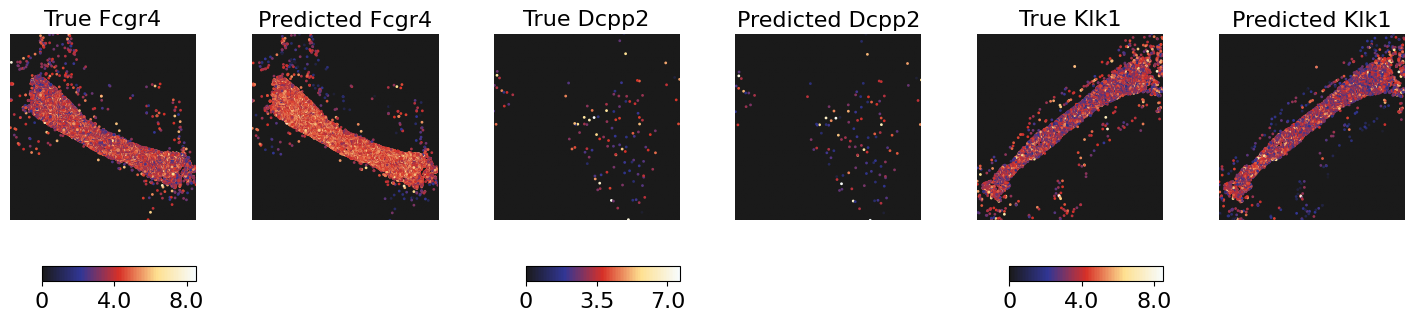

In [14]:
from sklearn.cluster import DBSCAN
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

colors = ['#1a1a1a','#313695', '#d73027', '#fee090', '#f7fcfd']
n_bins = 100  # Increase this number for smoother transitions
cmap = LinearSegmentedColormap.from_list('custom_green', colors, N=n_bins)

def remove_outlier_fill_hole(x, y, c, eps=500):
    points = np.stack([x, y, c], axis=1)

    # filter outlier
    clustering = DBSCAN(eps=eps, min_samples=2).fit(points[:, :2])
    core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
    core_samples_mask[clustering.core_sample_indices_] = True
    points_filtered = points[core_samples_mask]
    x, y, c = points_filtered[:, 0], points_filtered[:, 1], points_filtered[:, 2]

    # adjust to square
    x_min, x_max, y_min, y_max = x.min(), x.max(), y.min(), y.max()
    scale_x = (y_max - y_min) / (x_max - x_min)
    x = (x - x_min) * scale_x
    
    # create a grid for background
    points_outline = np.array([[x.min(), y.min()], [x.max(), y.min()], [x.min(), y.max()], [x.max(), y.max()]])
    grid_x, grid_y = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
    grid_z = griddata(points_outline, np.zeros_like(points_outline[:,0]), (grid_x, grid_y), method='linear')
    
    return x, y, c, grid_z

def subsample(idx, num=50000):
    if idx.shape[0] > num:
        sample_idx = np.random.permutation(idx)[:num]
        return sample_idx
    else:
        return idx

def plot_true_pred_gene_expression(marker_genes, samples, dir_path, filter_gene=True, eps=500):
    fig, axes = plt.subplots(1, 2*len(samples), figsize=(18, 4), gridspec_kw={'hspace': 1.0, 'wspace': 0.3})
    axes = axes.flatten()
    
    for i, (marker_gene, sample) in enumerate(zip(marker_genes, samples)):
        file_path = os.path.join(dir_path, sample) + '.h5ad'
        adata = sc.read(file_path)
        gene_filter_mask = adata.var['gene_filter_mask']
        if filter_gene:
            adata = adata[:, gene_filter_mask]  
        
        cell_centroid = adata.obsm['centroids']
        x, y = cell_centroid[:, 1], cell_centroid[:, 0]
    
        gene_mask = adata.var['gene_names']==marker_gene
        if gene_mask.sum() < 1:
            continue
            
        y_true = adata.X
        sum_norm = y_true.sum(-1, keepdims=True) + 1e-5
        y_true_m = y_true[:, gene_mask].reshape(-1, 1)
    
        file_path = result_path + f'{sample}_ours.npy'
        y_pred_ours = np.load(file_path)
        y_pred_ours_m = y_pred_ours[:, gene_mask].reshape(-1, 1)
        
        y_true_max_m = y_true_m.max()
        
        y_true_m, y_pred_ours_m = normalize(y_true_m), normalize(y_pred_ours_m)
        x_m, y_m = x, y

        ax = axes[2*i]
        x_new, y_new, c_new, grids = remove_outlier_fill_hole(x_m, y_m, y_true_m.squeeze(1), eps)
        ax.imshow(grids.T, extent=(x_new.min(), x_new.max(), y_new.min(), y_new.max()), cmap=cmap)
        sc1 = ax.scatter(x_new, y_new, c=c_new, s=1.0, cmap=cmap)
        ax.set_title(f'True {marker_gene}', fontsize=16)
        ax.axis('off') 
        ax.grid(False)

        cbar = fig.colorbar(sc1, location='bottom', orientation='horizontal', fraction=0.05, aspect=10, shrink=1.2, anchor=(1, 3), ax=ax)
        max_tick = float(int(y_true_max_m))
        cbar.set_ticks([0, max_tick/y_true_max_m/2, max_tick/y_true_max_m]) 
        cbar.set_ticklabels([0, max_tick / 2, max_tick])
        cbar.ax.tick_params(labelsize=16) 
        
        ax = axes[2*i+1]
        x_new, y_new, c_new, grids = remove_outlier_fill_hole(x_m, y_m, y_pred_ours_m.squeeze(1), eps)
        ax.imshow(grids.T, extent=(x_new.min(), x_new.max(), y_new.min(), y_new.max()), cmap=cmap)
        sc2 = ax.scatter(x_new, y_new, c=c_new, s=1.0, cmap=cmap)
        ax.set_title(f'Predicted {marker_gene}', fontsize=16)
        ax.axis('off') 
        ax.grid(False)
        
marker_genes = ['PTPRC', 'EPCAM', 'PECAM1']
samples = ['TENX123', 'TENX126', 'TENX124']
plot_true_pred_gene_expression(marker_genes, samples, dir_path1)
plt.tight_layout()
plt.savefig('../../figure/pred_xenium_demo_sample.png', dpi=300)

marker_genes = ['CXCL14', 'AGER', 'CD27']
samples = ['THD0008', 'VUILD78LA', 'VUILD48LA2']
plot_true_pred_gene_expression(marker_genes, samples, dir_path2)
plt.tight_layout()
plt.savefig('../../figure/pred_xenium_demo_lung.png', dpi=300)

marker_genes = ['Fcgr4', 'Dcpp2', 'Klk1']
samples = ['TENX136', 'TENX135', 'TENX137']
plot_true_pred_gene_expression(marker_genes, samples, dir_path1, filter_gene=False, eps=1500)
plt.tight_layout()
plt.savefig('../../figure/pred_xenium_demo_bone.png', dpi=300)

plt.show()

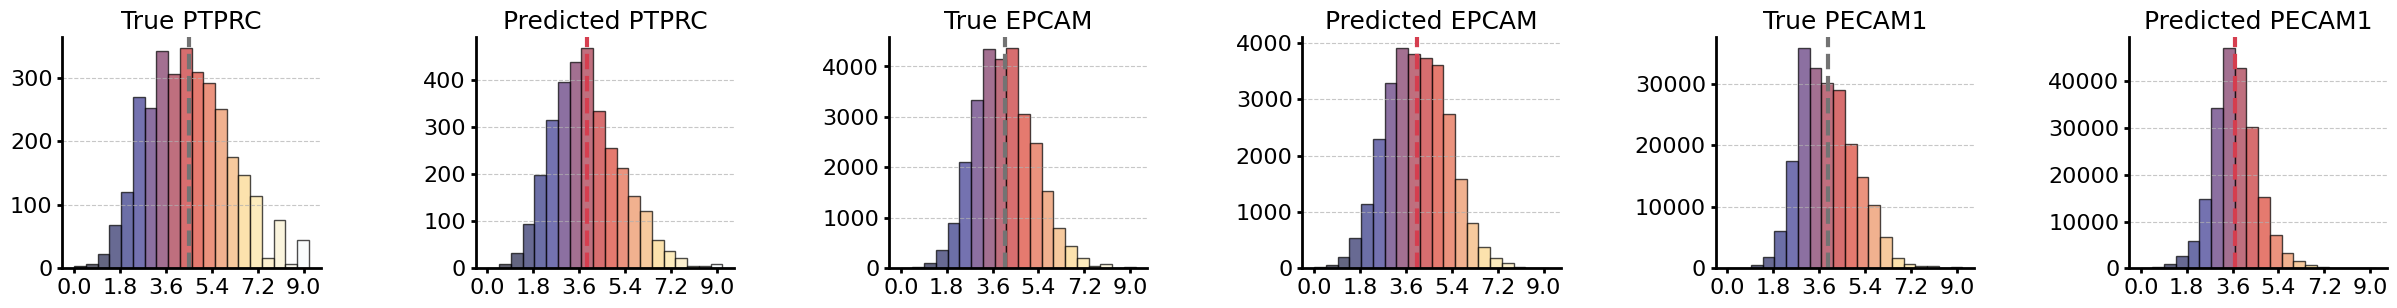

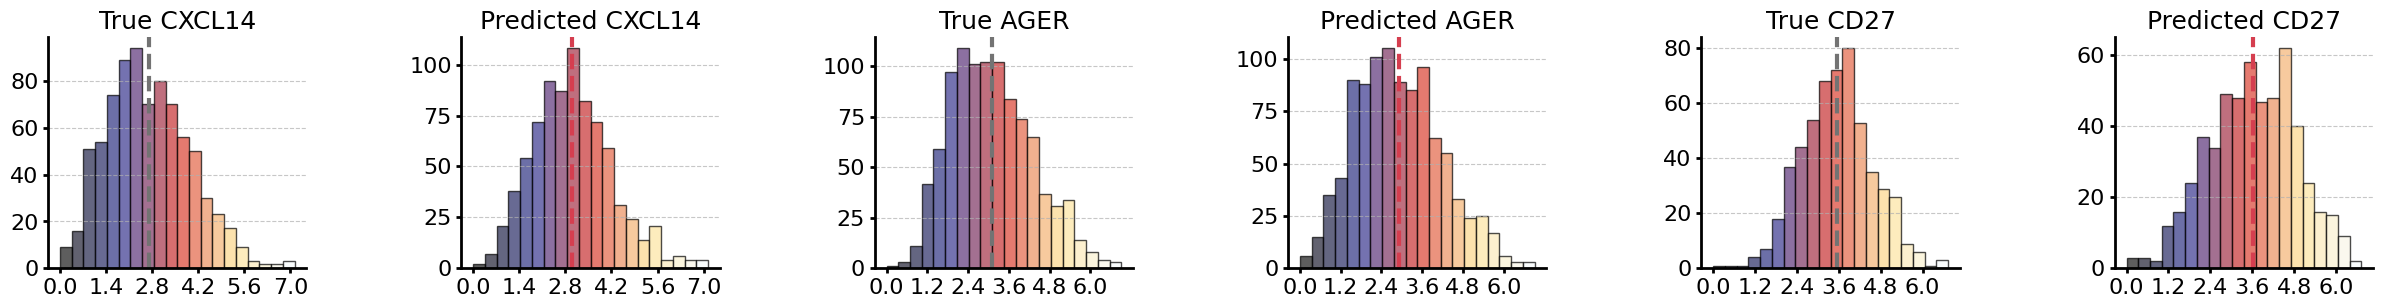

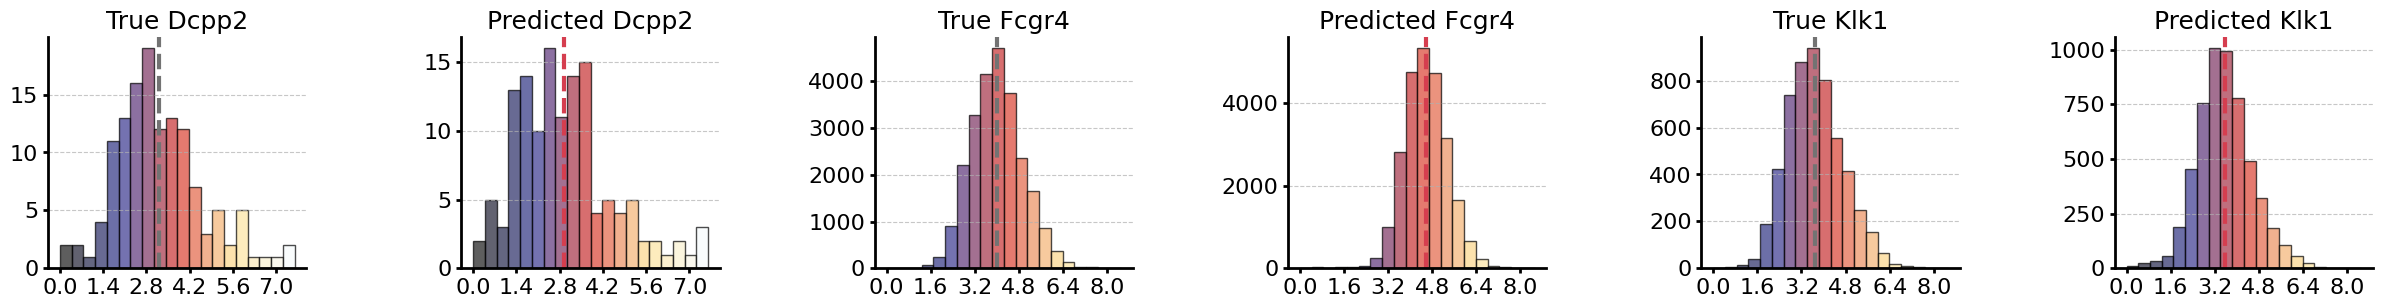

In [15]:
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
formatter = ticker.FuncFormatter(lambda x, _: f'{x:.1f}')

colors = ['#1a1a1a','#313695', '#d73027', '#fee090', '#f7fcfd']
n_bins = 100  # Increase this number for smoother transitions
cmap = LinearSegmentedColormap.from_list('custom_green', colors, N=n_bins)

def plot_true_pred_gene_expression_density(marker_genes, samples, dir_path, filter_gene=True, eps=500):
    fig, axes = plt.subplots(1, 2*len(samples), figsize=(30, 3), gridspec_kw={'hspace': 1.0, 'wspace': 0.6})
    axes = axes.flatten()
    
    for i, (marker_gene, sample) in enumerate(zip(marker_genes, samples)):
        file_path = os.path.join(dir_path, sample) + '.h5ad'
        adata = sc.read(file_path)
        gene_filter_mask = adata.var['gene_filter_mask']
        if filter_gene:
            adata = adata[:, gene_filter_mask]  
        
        cell_centroid = adata.obsm['centroids']
        x, y = cell_centroid[:, 1], cell_centroid[:, 0]
    
        gene_mask = adata.var['gene_names']==marker_gene
        if gene_mask.sum() < 1:
            continue
            
        y_true = adata.X
        sum_norm = y_true.sum(-1, keepdims=True) + 1e-5
        y_true_m = y_true[:, gene_mask].reshape(-1, 1)
    
        file_path = result_path + f'{sample}_ours.npy'
        y_pred_ours = np.load(file_path)
        y_pred_ours_m = y_pred_ours[:, gene_mask].reshape(-1, 1)
    
        y_true_max_m = y_true_m.max()
        y_true_m, y_pred_ours_m = normalize(y_true_m), normalize(y_pred_ours_m)
        
        x_m, y_m = x, y
        
        ax = axes[2*i]
        n, bins, patches = ax.hist(y_true_m, bins=20, color='#737373', edgecolor='black', alpha=0.7)
        ax.axvline(np.mean(y_true_m), color='#737373', linestyle='dashed', linewidth=3)
        # assign colors to histograms
        bin_centers = 0.5 * (bins[:-1] + bins[1:]) 
        norm = mcolors.Normalize(vmin=min(bin_centers), vmax=max(bin_centers)) 
        for patch, center in zip(patches, bin_centers):
            color = cmap(norm(center))
            patch.set_facecolor(color)
    
        ax.set_title(f'True {marker_gene}', fontsize=18)
        max_tick = float(int(y_true_max_m))
        ax.set_xticks([max_tick/y_true_max_m/5*i for i in range(6)]) 
        ax.set_xticklabels([f'{max_tick/5*i:.1f}' for i in range(6)])
        ax.tick_params(axis='x', labelsize=16, width=2)
        ax.tick_params(axis='y', labelsize=16, width=2)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)

        ax = axes[2*i+1]
        n, bins, patches = ax.hist(y_pred_ours_m, bins=20, color='#d53e4f', edgecolor='black', alpha=0.7)
        ax.axvline(np.mean(y_pred_ours_m), color='#d53e4f', linestyle='dashed', linewidth=3)
        # assign colors to histograms
        bin_centers = 0.5 * (bins[:-1] + bins[1:]) 
        norm = mcolors.Normalize(vmin=min(bin_centers), vmax=max(bin_centers)) 
        for patch, center in zip(patches, bin_centers):
            color = cmap(norm(center))
            patch.set_facecolor(color)
            
        ax.set_title(f'Predicted {marker_gene}', fontsize=18)
        ax.set_xticks([max_tick/y_true_max_m/5*i for i in range(6)]) 
        ax.set_xticklabels([f'{max_tick/5*i:.1f}' for i in range(6)])
        ax.tick_params(axis='x', labelsize=16, width=2)
        ax.tick_params(axis='y', labelsize=16, width=2)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        
        
marker_genes = ['PTPRC', 'EPCAM', 'PECAM1']
samples = ['TENX123', 'TENX126', 'TENX124']
plot_true_pred_gene_expression_density(marker_genes, samples, dir_path1)
plt.tight_layout()
plt.savefig('../../figure/pred_xenium_demo_sample_density.pdf')

marker_genes = ['CXCL14', 'AGER', 'CD27']
samples = ['THD0008', 'VUILD78LA', 'VUILD48LA2']
plot_true_pred_gene_expression_density(marker_genes, samples, dir_path2)
plt.tight_layout()
plt.savefig('../../figure/pred_xenium_demo_lung_density.pdf')

marker_genes = ['Dcpp2', 'Fcgr4', 'Klk1']
samples = ['TENX135', 'TENX136', 'TENX137']
plot_true_pred_gene_expression_density(marker_genes, samples, dir_path1, filter_gene=False, eps=1500)
plt.tight_layout()
plt.savefig('../../figure/pred_xenium_demo_bone_density.pdf')

plt.show()

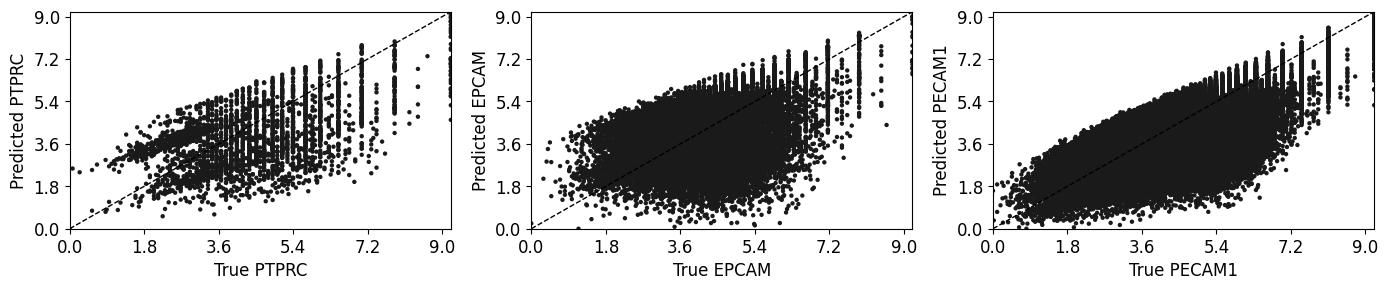

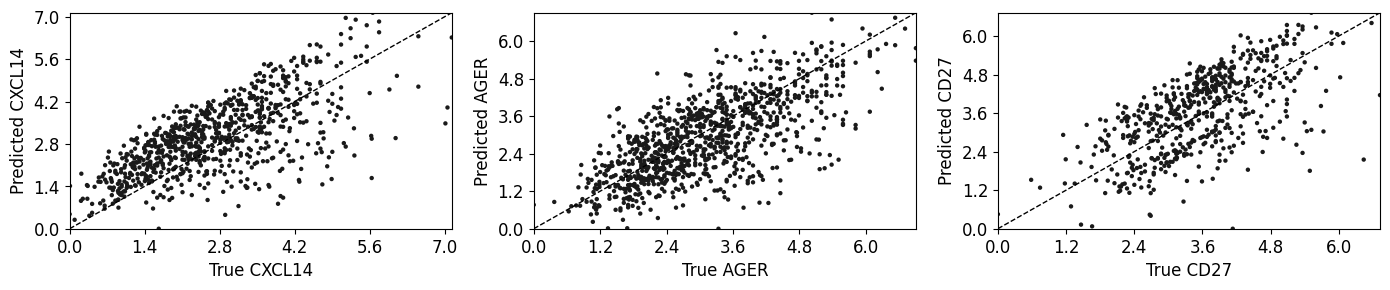

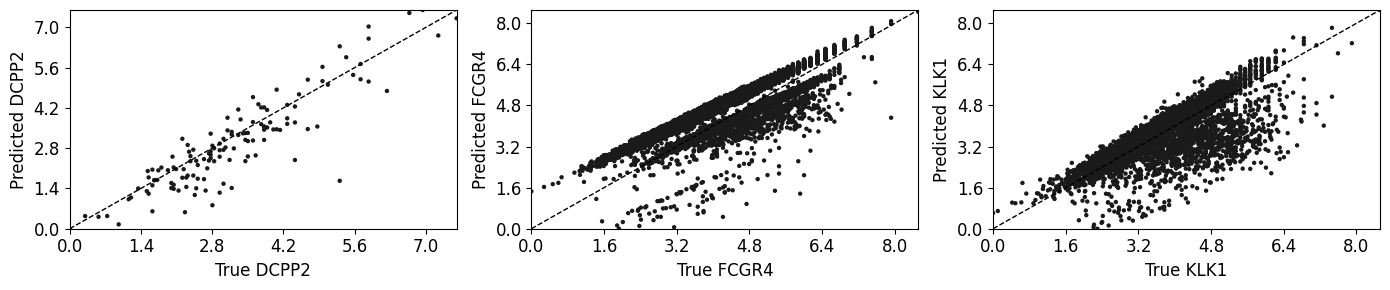

In [16]:
def plot_pred_true(marker_genes, samples, dir_path, filter_gene=True):
    fig, axes = plt.subplots(1, 3, figsize=(14, 3))
    axes = axes.flatten()
    for i, (marker_gene, sample) in enumerate(zip(marker_genes, samples)):
        
        file_path = os.path.join(dir_path, sample) + '.h5ad'
        adata = sc.read(file_path)
        gene_filter_mask = adata.var['gene_filter_mask']
        if filter_gene:
            adata = adata[:, gene_filter_mask]  
        
        cell_centroid = adata.obsm['centroids']
        x, y = cell_centroid[:, 1], cell_centroid[:, 0]
    
        gene_mask = adata.var['gene_names']==marker_gene
        if gene_mask.sum() < 1:
            continue
            
        y_true = adata.X
        sum_norm = y_true.sum(-1, keepdims=True) + 1e-5
        y_true_m = y_true[:, gene_mask].reshape(-1, 1)
    
        file_path = result_path + f'{sample}_ours.npy'
        y_pred_ours = np.load(file_path)
        y_pred_ours_m = y_pred_ours[:, gene_mask].reshape(-1, 1)
        
        y_true_max_m = y_true_m.max()
        
        y_true_m, y_pred_ours_m = normalize(y_true_m), normalize(y_pred_ours_m)
        x_m, y_m = x, y
        
        ax = axes[i]
        ax.scatter(y_true_m, y_pred_ours_m, color='#1a1a1a', edgecolors='none', s=10.0)
        ax.set_xlabel(f'True {marker_gene.upper()}', fontsize=12)
        ax.set_ylabel(f'Predicted {marker_gene.upper()}', fontsize=12)
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        max_tick = float(int(y_true_max_m))
        ax.set_xticks([max_tick/y_true_max_m/5*i for i in range(6)]) 
        ax.set_xticklabels([f'{max_tick/5*i:.1f}' for i in range(6)])
        ax.set_yticks([max_tick/y_true_max_m/5*i for i in range(6)]) 
        ax.set_yticklabels([f'{max_tick/5*i:.1f}' for i in range(6)])
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.plot([0, 1], [0, 1], color="k", linestyle="--", linewidth=1)

marker_genes = ['PTPRC', 'EPCAM', 'PECAM1']
samples = ['TENX123', 'TENX126', 'TENX124']
plot_pred_true(marker_genes, samples, dir_path1)
plt.tight_layout()
plt.savefig('../../figure/pred_xenium_demo_sample_scatter.png', dpi=300)

marker_genes = ['CXCL14', 'AGER', 'CD27']
samples = ['THD0008', 'VUILD78LA', 'VUILD48LA2']
plot_pred_true(marker_genes, samples, dir_path2)
plt.tight_layout()
plt.savefig('../../figure/pred_xenium_demo_lung_scatter.png', dpi=300)

marker_genes = ['Dcpp2', 'Fcgr4' , 'Klk1']
samples = ['TENX135', 'TENX136', 'TENX137']
plot_pred_true(marker_genes, samples, dir_path1, filter_gene=False)
plt.tight_layout()
plt.savefig('../../figure/pred_xenium_demo_bone_scatter.png', dpi=300)

['ABCC11' 'ACKR1' 'ADGRL4' 'ADIPOQ' 'AGER' 'AHSP' 'ALAS2' 'ANGPT2'
 'APOBEC3A' 'AQP2' 'ASCL3' 'BAMBI' 'BMX' 'C5orf46' 'CA4' 'CCDC39' 'CCDC78'
 'CD1E' 'CD274' 'CD300E' 'CD68' 'CD70' 'CDH16' 'CENPF' 'CHGA' 'CLCA1'
 'CLEC10A' 'CLIC5' 'CPA3' 'CSF3' 'CTSG' 'CXCL10' 'CYP2F1' 'DMBT1' 'DNAAF1'
 'ELF5' 'ESR1' 'FCER1A' 'FCN1' 'FOXA1' 'FOXI1' 'FOXJ1' 'FOXP3' 'GCG'
 'GHRL' 'GKN2' 'GNLY' 'GYPB' 'GZMB' 'HAVCR2' 'HES4' 'HIGD1B' 'IL1RL1'
 'INS' 'KCNK3' 'KIT' 'KRT20' 'LAG3' 'LAMP3' 'LGI4' 'LILRA4' 'LILRA5'
 'LILRB2' 'LILRB4' 'MCEMP1' 'MLANA' 'MS4A2' 'NAT8' 'OPRPN' 'PCOLCE' 'PGR'
 'PLA2G7' 'PLAC9' 'PNP' 'PVALB' 'RERGL' 'RETN' 'RGS16' 'SELE' 'SLC18A2'
 'SLC22A8' 'SLC4A1' 'SNAI1' 'SNCA' 'SNTN' 'SOX17' 'SOX2' 'SPDEF' 'SPI1'
 'SRPX' 'SST' 'STC1' 'TCF15' 'TFF2' 'TM4SF18' 'TMEM52B' 'TREM2' 'UBE2C'
 'UMOD' 'VSIG4']
0.39602083 0.4625524 0.47179666 0.5437461


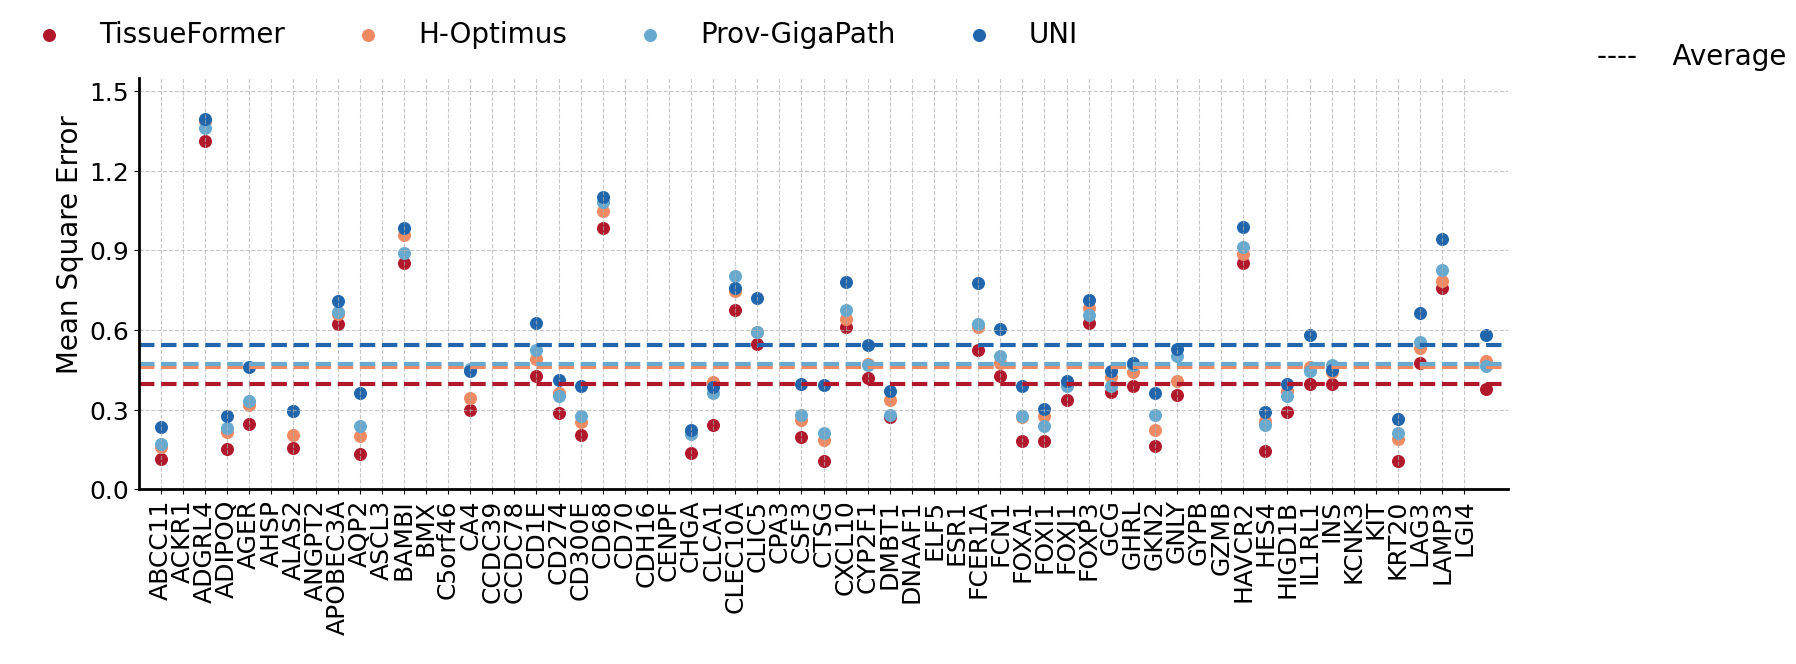

In [17]:
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list

genes, labels = [], []
scores_ours, scores_hoptimus, scores_gigapath, scores_uni, scores_pca, scores_visium = [], [], [], [], [], []

samples = ['TENX126', 'TENX123', 'TENX124', 'TENX121', 'TENX119', 'TENX118']
organs = ['Pancreas', 'Skin', 'Lymphoid', 'Liver', 'Heart', 'Lung']

marker_genes = ['SNAI1', 'PVALB', 'LILRA4', 'FCN1', 'CYP2F1', 'CHGA', 'CD274', 'CD68', 'MCEMP1', 'CA4', 
                'UBE2C', 'KRT20', 'UMOD', 'ALAS2', 'ADIPOQ', 'FOXA1', 'APOBEC3A', 'GHRL', 'GNLY', 'INS', 
                'SELE', 'HAVCR2', 'NAT8', 'GCG', 'VSIG4', 'FOXP3', 'CXCL10', 'BAMBI', 'ABCC11', 'AQP2', 
                'CTSG', 'HES4', 'SST', 'OPRPN', 'SLC18A2', 'ADGRL4', 'SLC4A1', 'CD300E', 'MLANA', 'CSF3', 
                'CLIC5', 'SOX17', 'DMBT1', 'GKN2', 'TMEM52B', 'HIGD1B', 'SOX2', 'LAMP3', 'CD1E', 'LAG3', 
                'FOXJ1', 'FCER1A', 'PLAC9', 'RETN', 'CLEC10A', 'IL1RL1', 'FOXI1', 'CLCA1', 'AGER', 'TREM2', 
                'CENPF', 'AHSP', 'LILRA5', 'SPDEF', 'RGS16', 'LILRB4', 'DNAAF1', 'PLA2G7', 'ASCL3', 'TM4SF18', 
                'KIT', 'SLC22A8', 'LILRB2', 'PGR', 'MS4A2', 'ACKR1', 'ELF5', 'ANGPT2', 'PNP', 'GZMB', 'ESR1', 
                'BMX', 'CCDC39', 'LGI4', 'SNCA', 'CDH16', 'C5orf46', 'TFF2', 'RERGL', 'TCF15', 'KCNK3', 'STC1', 
                'CPA3', 'SNTN', 'PCOLCE', 'CCDC78', 'GYPB', 'CD70', 'SPI1', 'SRPX'] 

for s, sample in enumerate(samples):
    file_path = os.path.join(dir_path1, sample) + '.h5ad'
    adata = sc.read(file_path)
    gene_filter_mask = adata.var['gene_filter_mask']
    adata = adata[:, gene_filter_mask]
    
    file_path = result_path + f'{sample}_true.npy'
    y_true = np.load(file_path)
    file_path = result_path + f'{sample}_ours.npy'
    y_pred = np.load(file_path)
    file_path = result_path + f'{sample}_hoptimus-MLP.npy'
    y_pred_hoptimus = np.load(file_path)
    file_path = result_path + f'{sample}_gigapath-MLP.npy'
    y_pred_gigapath = np.load(file_path)
    file_path = result_path + f'{sample}_uni-MLP.npy'
    y_pred_uni = np.load(file_path)

    for marker_gene in marker_genes:
        gene_mask = adata.var['gene_names']==marker_gene
        if gene_mask.sum() < 1:
            continue
        y_true_m, y_pred_m = y_true[:, gene_mask].reshape(-1, 1), y_pred[:, gene_mask].reshape(-1, 1)
        y_pred_hoptimus_m, y_pred_gigapath_m, y_pred_uni_m = \
            y_pred_hoptimus[:, gene_mask].reshape(-1, 1), y_pred_gigapath[:, gene_mask].reshape(-1, 1), y_pred_uni[:, gene_mask].reshape(-1, 1)

        scores_ours += [((y_true_m - y_pred_m)**2).mean()]
        scores_hoptimus += [((y_true_m - y_pred_hoptimus_m)**2).mean()]
        scores_gigapath += [((y_true_m - y_pred_gigapath_m)**2).mean()]
        scores_uni += [((y_true_m - y_pred_uni_m)**2).mean()]
        genes += [marker_gene]
        labels += [organs[s]]

marker_genes_sorted = np.sort(np.array(marker_genes))
xs = {g:i for i, g in enumerate(marker_genes_sorted)}
print(marker_genes_sorted)

fig, ax = plt.subplots(figsize=(18, 7))

model_color = ['#b2182b', '#ef8a62', '#67a9cf', '#2166ac', '#2166ac']
model_names = ['TissueFormer', 'H-Optimus', 'Prov-GigaPath', 'UNI', 'PCA']

genes = np.array(genes)
labels = np.array(labels)
scores_ours, scores_hoptimus, scores_gigapath, scores_uni = \
    np.array(scores_ours), np.array(scores_hoptimus), np.array(scores_gigapath), np.array(scores_uni)

for i, g in enumerate(marker_genes[:60]):
    mask_g = genes==g
    avg_score_ours_g = scores_ours[mask_g].mean()
    avg_score_hoptimus_g = scores_hoptimus[mask_g].mean()
    avg_score_gigapath_g = scores_gigapath[mask_g].mean()
    avg_score_uni_g = scores_uni[mask_g].mean()

    h1 = ax.scatter(xs[g], avg_score_ours_g, color=model_color[0], s=70, alpha=1.0, marker='o', label=model_names[0])
    h2 = ax.scatter(xs[g], avg_score_hoptimus_g, color=model_color[1], s=70, alpha=1.0, marker='o', label=model_names[1])
    h3 = ax.scatter(xs[g], avg_score_gigapath_g, color=model_color[2], s=70, alpha=1.0, marker='o', label=model_names[2])
    h4 = ax.scatter(xs[g], avg_score_uni_g, color=model_color[3], s=70, alpha=1.0, marker='o', label=model_names[3])
    
    if i==0:
        handles = [h1, h2, h3, h4]

avg_score_ours = scores_ours.mean()
ax.hlines(y=avg_score_ours, xmin=-1, xmax=61, colors=model_color[0], linestyles='--', linewidth=3.0)
avg_score_hoptimus = scores_hoptimus.mean()
ax.hlines(y=avg_score_hoptimus, xmin=-1, xmax=61, colors=model_color[1], linestyles='--', linewidth=3.0)
avg_score_gigapath = scores_gigapath.mean()
ax.hlines(y=avg_score_gigapath, xmin=-1, xmax=61, colors=model_color[2], linestyles='--', linewidth=3.0)
avg_score_uni = scores_uni.mean()
ax.hlines(y=avg_score_uni, xmin=-1, xmax=61, colors=model_color[3], linestyles='--', linewidth=3.0)

print(avg_score_ours, avg_score_hoptimus, avg_score_gigapath, avg_score_uni)

ax.set_xlabel(" ", fontsize=10)
ax.set_ylabel("         Mean Square Error", fontsize=20)
ax.set_xlim(-1, 61)
ax.set_xticks(ticks=range(len(marker_genes_sorted[:60])), labels=marker_genes_sorted[:60], rotation=90)
ax.set_ylim(0, 1.55)
ax.set_yticks([0., 0.3, 0.6, 0.9, 1.2, 1.5]) 

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

ax.legend(handles, model_names, loc='upper center', fontsize=20, ncols=5, bbox_to_anchor=(0.3, 1.2), frameon=False)
ax.text(65, 1.6, '----    Average', verticalalignment='baseline', fontsize=20)

plt.tight_layout()
plt.savefig('../../figure/pred_xenium_genewise_sample.pdf')
plt.show()


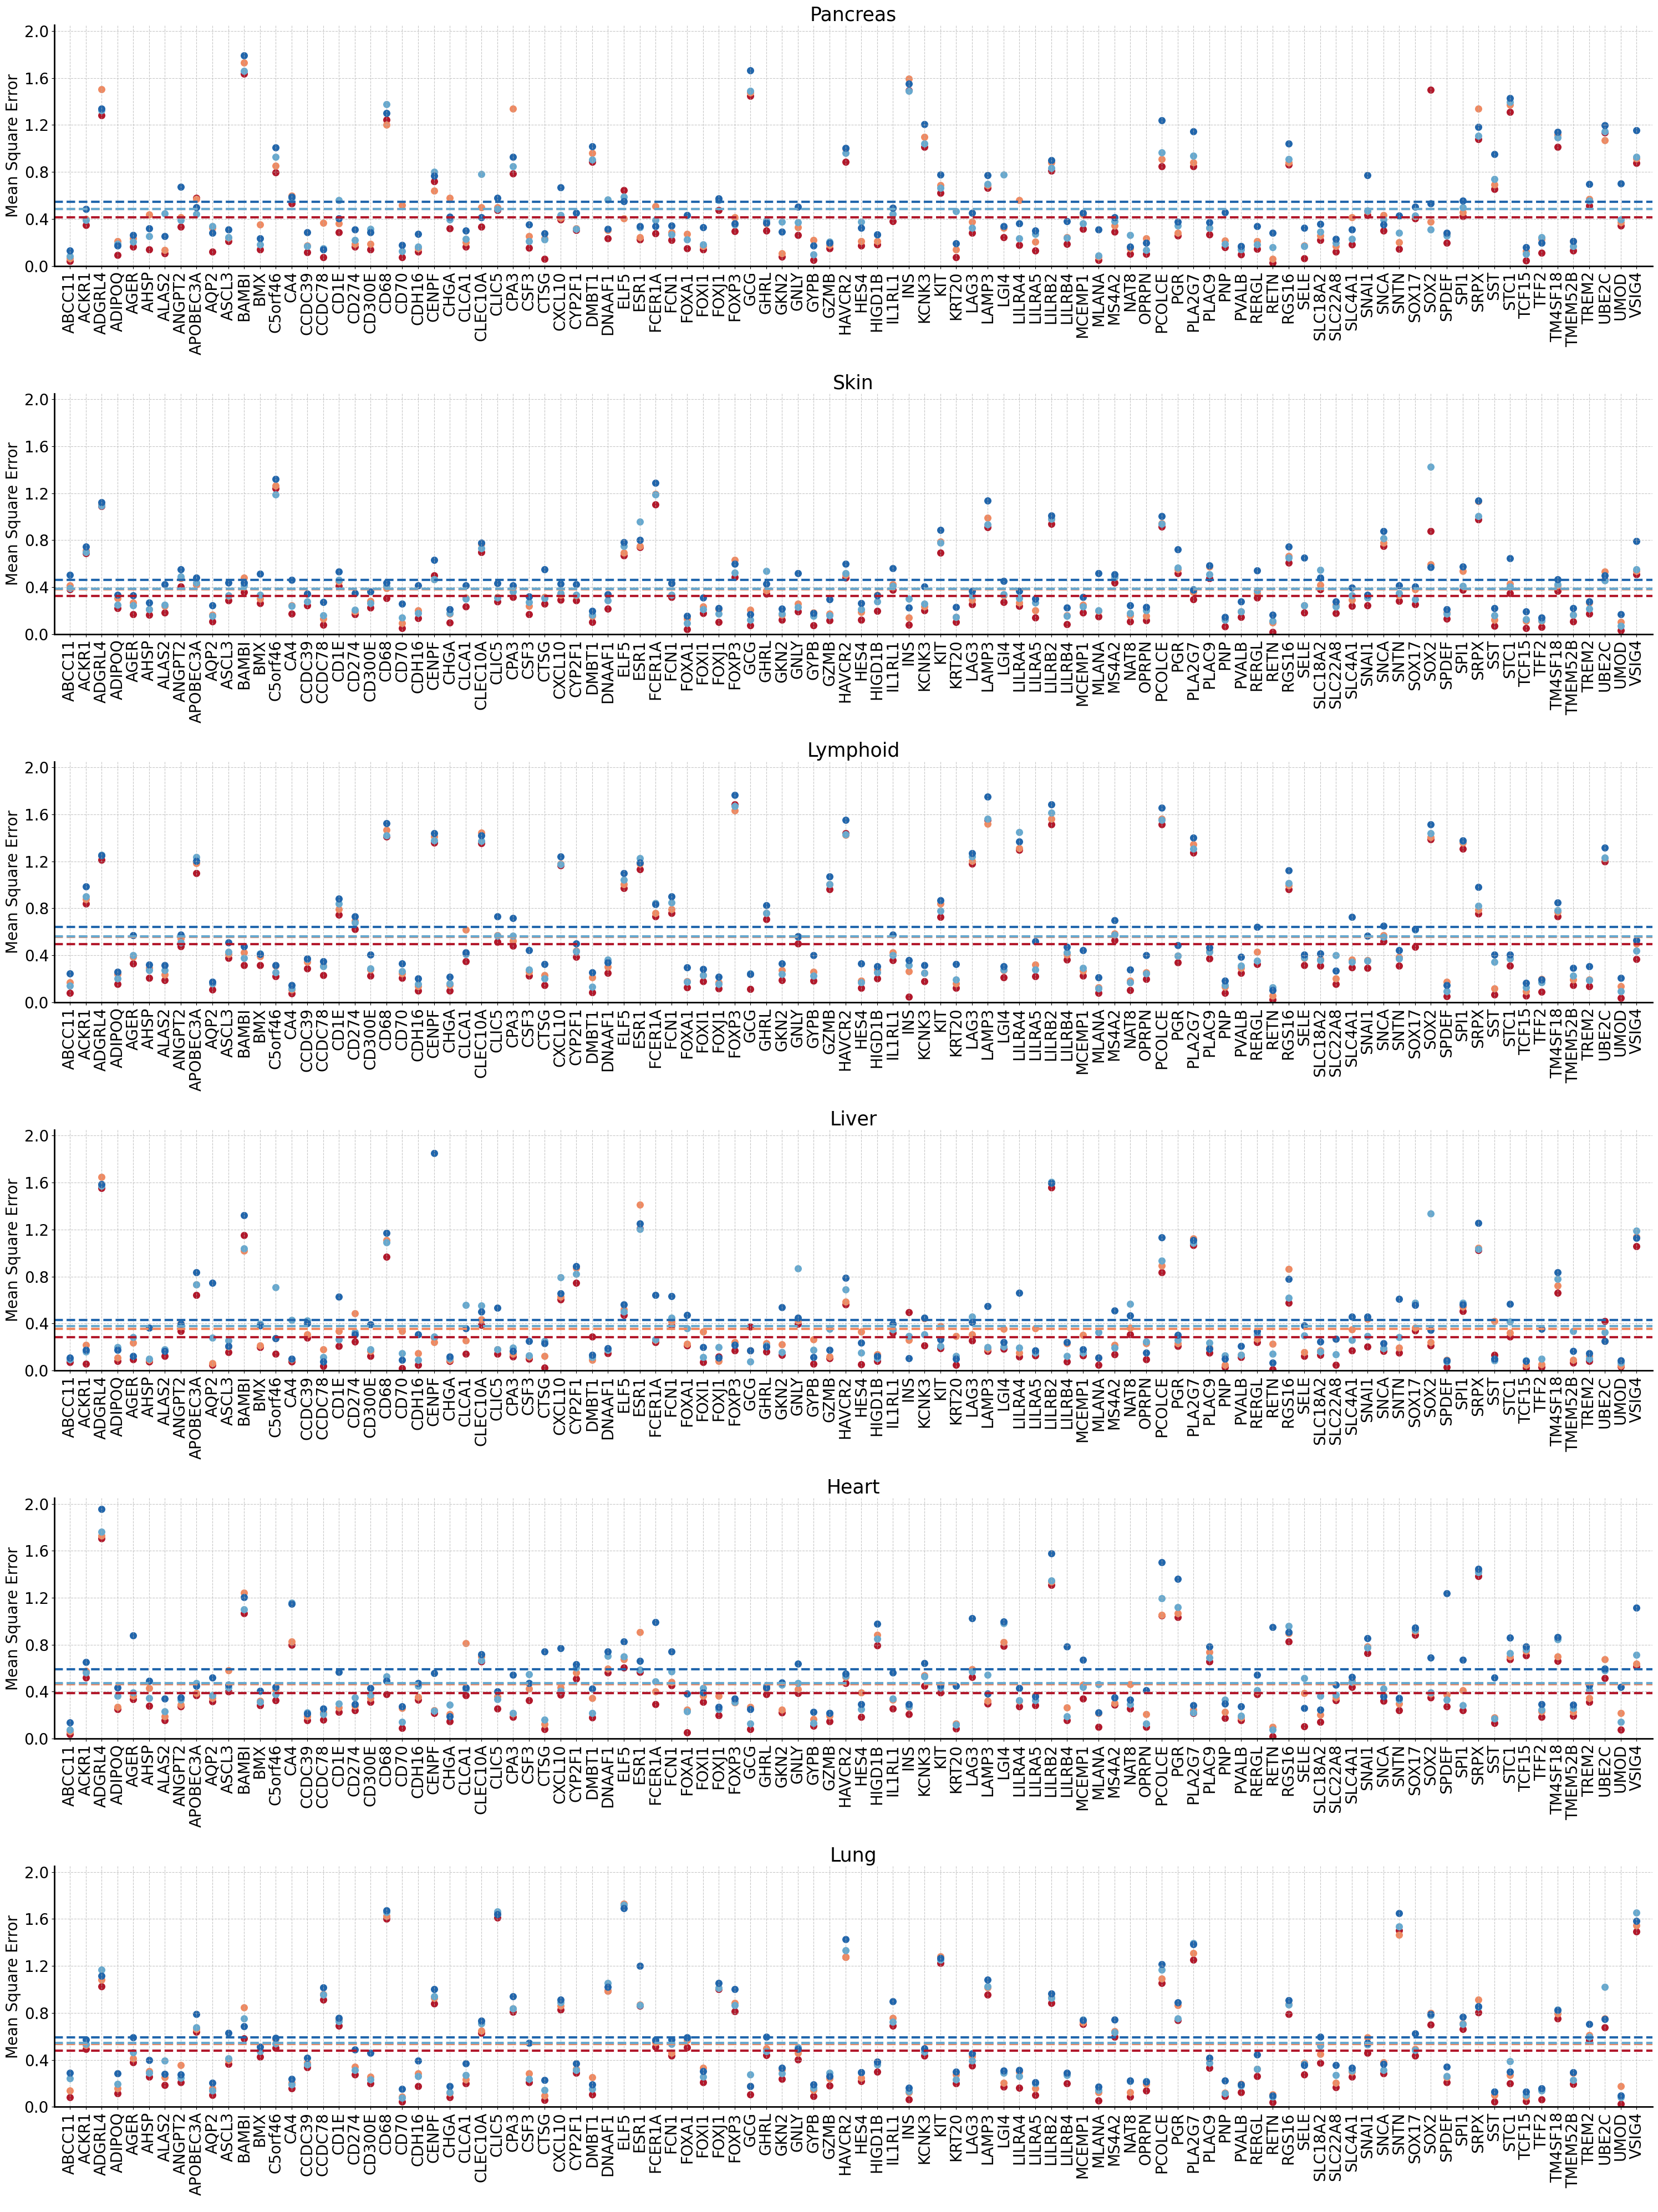

In [18]:
fig, axes = plt.subplots(6, 1, figsize=(30, 40))
axes = axes.flatten()

for k, o in enumerate(organs):
    ax = axes[k]
    mask_o = labels==o
    scores_ours_o = scores_ours[mask_o]
    scores_hoptimus_o = scores_hoptimus[mask_o]
    scores_gigapath_o = scores_gigapath[mask_o]
    scores_uni_o = scores_uni[mask_o]
    for i, g in enumerate(marker_genes):
        mask_g = genes[mask_o]==g
        avg_score_ours_g = scores_ours_o[mask_g].mean()
        avg_score_hoptimus_g = scores_hoptimus_o[mask_g].mean()
        avg_score_gigapath_g = scores_gigapath_o[mask_g].mean()
        avg_score_uni_g = scores_uni_o[mask_g].mean()

        if i==0:
            handles = [h1, h2, h3, h4]
    
    avg_score_ours = scores_ours_o.mean()
    ax.hlines(y=avg_score_ours, xmin=-1, xmax=100, colors=model_color[0], linestyles='--', linewidth=3.0)
    avg_score_hoptimus = scores_hoptimus_o.mean()
    ax.hlines(y=avg_score_hoptimus, xmin=-1, xmax=100, colors=model_color[1], linestyles='--', linewidth=3.0)
    avg_score_gigapath = scores_gigapath_o.mean()
    ax.hlines(y=avg_score_gigapath, xmin=-1, xmax=100, colors=model_color[2], linestyles='--', linewidth=3.0)
    avg_score_uni = scores_uni_o.mean()
    ax.hlines(y=avg_score_uni, xmin=-1, xmax=100, colors=model_color[3], linestyles='--', linewidth=3.0)
    
    ax.set_xlabel(" ", fontsize=10)
    ax.set_ylabel("Mean Square Error", fontsize=20)
    ax.set_xlim(-1, 100)
    ax.set_xticks(ticks=range(len(marker_genes_sorted)), labels=marker_genes_sorted, rotation=90)
    ax.set_ylim(0, 2.05)
    ax.set_yticks([0., 0.4, 0.8, 1.2, 1.6, 2.0])
    ax.set_title(f"{o}", fontsize=25)
    
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)

plt.tight_layout()
plt.savefig('../../figure/pred_xenium_genewise_sample_all.pdf')
plt.show()

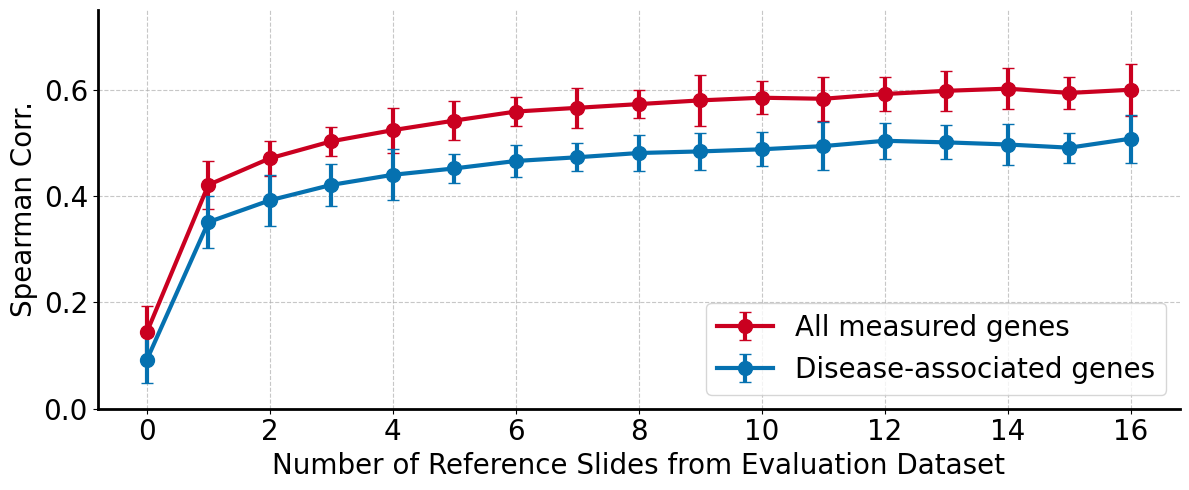

In [22]:
import matplotlib.pyplot as plt
import numpy as np

y1 = [0.144, 0.421, 0.471, 0.503, 0.524, 0.542, 0.559, 0.566, 0.573, 0.580, 0.585,
      0.583, 0.592, 0.598, 0.602, 0.594, 0.600]
y1_err = [0.0491408 , 0.04520993, 0.03261534, 0.0274418 , 0.04210583,
       0.03600381, 0.02805096, 0.03737942, 0.02585971, 0.04773301,
       0.0314695 , 0.04156306, 0.03279278, 0.0380017 , 0.03866776,
       0.02962136, 0.04923962]
y2 = [0.092, 0.351, 0.392, 0.421, 0.440, 0.452, 0.466, 0.473, 0.481, 0.484, 0.488,
      0.494, 0.504, 0.501, 0.497, 0.491, 0.508]
y2_err = [0.04437832, 0.04848747, 0.04737068, 0.0399475 , 0.04804686,
       0.02721231, 0.02989957, 0.02613068, 0.03313326, 0.03471693,
       0.03178373, 0.04571844, 0.03391883, 0.03202336, 0.0385674 ,
       0.02852311, 0.04505492]

x = [i for i in range(17)]

data = {
    'All measured genes': (y1, y1_err),
    'Disease-associated genes': (y2, y2_err)
}
colors = ['#ca0020', '#0571b0']

fig, ax = plt.subplots(figsize=(12, 5))

for i, (label, y) in enumerate(data.items()):
    plt.errorbar(x, y[0], yerr=y[1], label=label, marker='o', markersize=10, capsize=4, linestyle='-', linewidth=3, color=colors[i])

ax.set_xlabel('Number of Reference Slides from Evaluation Dataset', fontsize=20)
ax.set_ylabel('Spearman Corr.', fontsize=20)
ax.set_ylim(0, 0.75)
plt.legend(loc='lower right', fontsize=20, ncols=1, frameon=True)
plt.grid(False)

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

plt.tight_layout()
plt.savefig('../../figure/pred_xenium_number_ref.pdf')
plt.show()